# Comparing axis-aligned decision tree versus oblique decision tree on sklearn digits dataset
Here we extend our analysis beyound our previous `Iris` and `simulation` datasets to measure performance of oblique forest against random forset on sklearn digits dataset. We assessed performance of each algorithm using one verus rest ROC-AUC score followed by multi-class confusion matrix. As seen from previous notebooks, OF outperforms RF in this real-world setting as well.

### Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


### Import packages

In [2]:
import sklearn
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier

import os
import time
import pickle
import itertools
from tqdm import tqdm
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456
np.random.seed(random_state)
CLABEL = ['RF', 'OF']

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-06-29'

#### Load `digits` dataset from sklearn dataset module
The sklearn digits dataset consists of 8x8 arrays of grayscale values of hand-written digits. More information is available in this [document](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)

In [4]:
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
data.data.shape, data.target.shape

((1797, 64), (1797,))

In [6]:
X = data.data
y = data.target

Text(0.5, 1.0, '0')

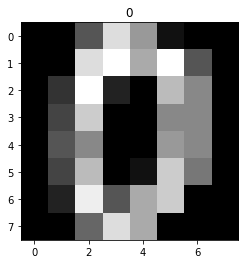

In [7]:
plt.imshow(X[0,:].reshape(8,8), cmap='gray')
plt.title(y[0])

### train-test-split digits dataset
For this cross-validation accuracy measure, we are only using 1/10 of the digits data to limit the size of training data

In [8]:
XX, _, yy, _ = train_test_split(X, y, test_size=0.9, random_state=random_state)
Counter(y), Counter(yy)

(Counter({0: 178,
          1: 182,
          2: 177,
          3: 183,
          4: 181,
          5: 182,
          6: 181,
          7: 179,
          8: 174,
          9: 180}),
 Counter({8: 16,
          7: 16,
          1: 15,
          9: 15,
          2: 12,
          0: 27,
          6: 17,
          3: 22,
          5: 24,
          4: 15}))

In [9]:
clf = RandomForestClassifier(max_features=None, random_state=random_state)
cross_val_score(clf, X=XX, y=yy, cv=10, scoring='accuracy').mean()

0.8428104575163398

In [10]:
clf = ObliqueRandomForestClassifier(max_features=None, random_state=random_state)
cross_val_score(clf, X=XX, y=yy, cv=10, scoring='accuracy').mean()

0.9316993464052287

### Accuracy measure w.r.t. `max_features`
In addition to the mean accuracy over 10 CVs, we assessed the difference (OF-RF) over 10 CVs using different values for `max_features`

In [11]:
def run_experiment(X, y, cv=10):
    max_features = ['sqrt', X.shape[1]]

    output = []

    for mf in max_features:
        tmp = [f'{mf}']

        clfs = [
            RandomForestClassifier(max_features=mf, random_state=random_state),
            ObliqueRandomForestClassifier(max_features=mf, random_state=random_state)
        ]

        for clf in clfs:
            cv_score = cross_val_score(clf, X=X, y=y, cv=cv, scoring='accuracy')
            tmp.append(cv_score)
        
        output.append(tmp)

    df_out = pd.DataFrame(output, columns=['max_features', 'RF', 'OF']).explode(['RF','OF'])
    df_out['delta'] = df_out.apply(lambda x: x.OF-x.RF, axis=1)

    # print('Run Complete')

    return df_out

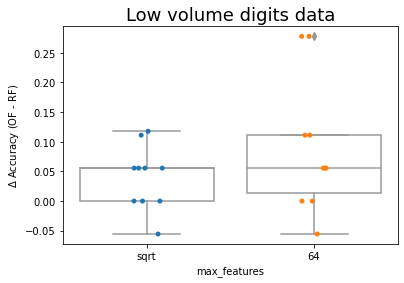

In [12]:
df_out = run_experiment(X=XX, y=yy)

fig, ax = plt.subplots()
sns.stripplot(data=df_out, x='max_features', y='delta', ax=ax)
sns.boxplot(data=df_out, x='max_features', y='delta', ax=ax, color='white')
ax.set_ylabel(r'$\Delta$ Accuracy (OF - RF)')
ax.set_title('Low volume digits data', fontsize=18);

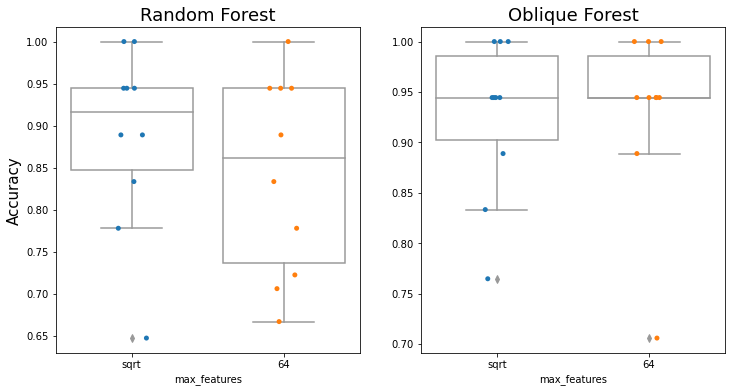

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i, j in enumerate(['RF', 'OF']):
    sns.stripplot(data=df_out, x='max_features', y=j, ax=ax[i])
    sns.boxplot(data=df_out, x='max_features', y=j, ax=ax[i], color='white')

ax[0].set_ylabel(r'Accuracy', fontsize=15)
ax[1].set_ylabel('', fontsize=15)
ax[0].set_title('Random Forest', fontsize=18);
ax[1].set_title('Oblique Forest', fontsize=18);

#### OvR multi-class ROC curves for the sklearn digits dataset
One versus rest ROC-AUC assessment for multi-class setting. The code to compute and draw ROC-AUC curves are mostly adapted from sklearn [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [14]:
def compute_ROC_AUC(y_test_10, y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_10[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_10.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return roc_auc, fpr, tpr

In [15]:
def draw_ROC(name, roc_auc, tpr, fpr):
    lw = 2 #line width
    tab10 = plt.get_cmap('tab10', 10) #color iterable

    # Plot all ROC curves
    plt.figure(figsize=(10,7))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = tab10(np.linspace(0, 1, 10))
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            alpha=0.4
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title(f"Multiclass ROC curve for {name}", fontsize=15)
    plt.legend(loc="lower right")
    plt.show()
    # return plt.figure

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=random_state)
n_classes = len(set(y_test))
print(f'There are {n_classes} classes')
# Counter(y_train), Counter(y_test)

There are 10 classes


In [17]:
clfs = [
    RandomForestClassifier(max_features=None, random_state=random_state),
    ObliqueRandomForestClassifier(max_features=None, random_state=random_state)
]

In [18]:
# Random Forest Parameters
clfs[0].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123456,
 'verbose': 0,
 'warm_start': False}

In [19]:
# Oblique Forest Parameters
clfs[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'feature_combinations': 1.5,
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123456,
 'verbose': 0,
 'warm_start': False}

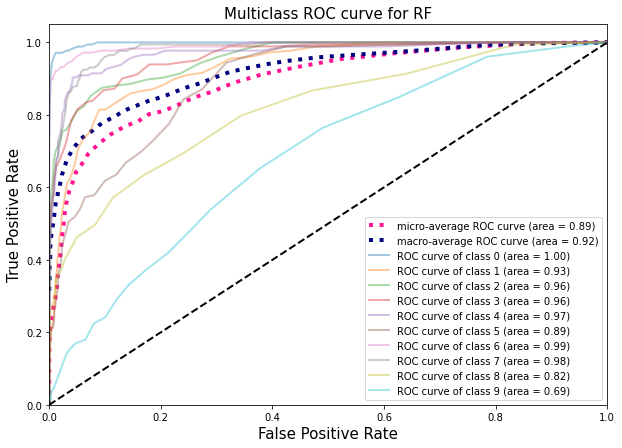

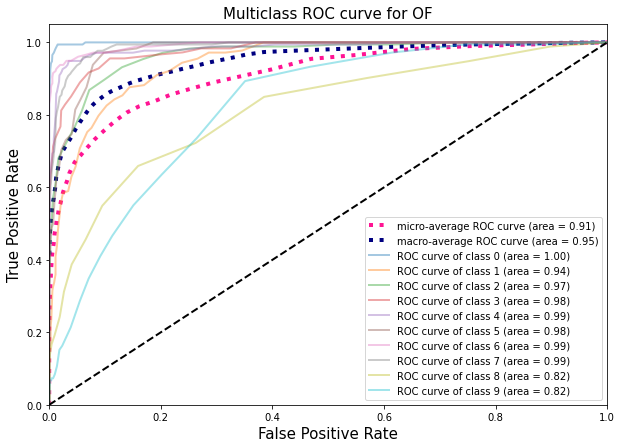

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_10 = label_binarize(y_test, classes=range(n_classes))
confusion_matrix = []

for name, clf in zip(['RF', 'OF'], clfs):
    # clf_ovr = OneVsRestClassifier(estimator=clf)
    # y_score = clf_ovr.fit(X_train, y_train).predict_proba(X_test)
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)

    confusion_matrix.append(
        [name, np.argmax(y_test_10, axis=1), np.argmax(y_score, axis=1)]
    )

    roc_auc, fpr, tpr = compute_ROC_AUC(y_test_10, y_score)
    fig = draw_ROC(name, roc_auc, tpr, fpr)

### Optimized Model Comparison via Grid Searching
The following is the optimized result from grid searching best paramters of three features: `max_features`, `n_estimators`, `max_depth`

In [21]:
# number of grid searching iteration
n_gridCV = 20

In [22]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [i for i in range(100,300,100)],
    'max_depth': [5,10,15,20,None]
}

df_cv = pd.DataFrame()
feat_cols = list(params.keys())+['mean_test_score','clf','mean_fit_time',
                                'std_fit_time','mean_score_time',
                                'std_score_time','params'
                                ]
clfs = [
    RandomForestClassifier(random_state=random_state),
    ObliqueRandomForestClassifier(random_state=random_state)
]

XX, _, yy, _ = train_test_split(X, y, test_size=0.90, random_state=random_state)

for clf, clf_lab in zip(clfs, ['RF', 'OF']):
    t_i = time.time()

    search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=n_gridCV, random_state=random_state)
    search.fit(X, y)
    print(f'Grid Searching {n_gridCV} parameter combinations took {int(time.time()-t_i)} seconds for {clf_lab} algorithm')
    
    df_tmp = pd.DataFrame(search.cv_results_)
    df_tmp.columns = [i.replace('param_','') for i in df_tmp.columns]
    df_tmp['clf'] = clf_lab
    # df_tmp.fillna('None', inplace=True)
    df_tmp['mean_test_score'] = df_tmp.apply(lambda x: round(x['mean_test_score'], 3), axis=1)
    df_cv = pd.concat([df_cv, df_tmp])

Grid Searching 20 parameter combinations took 50 seconds for RF algorithm
Grid Searching 20 parameter combinations took 105 seconds for OF algorithm


In [23]:
rf_best_param = df_cv.query('rank_test_score==1 and clf=="RF"')[list(params.keys())].to_dict('records')[0]
of_best_param = df_cv.query('rank_test_score==1 and clf=="OF"')[list(params.keys())].to_dict('records')[0]

In [24]:
rf_best_param, of_best_param

({'max_features': 'sqrt', 'n_estimators': 200, 'max_depth': 15},
 {'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10})

### Robustedness test using batched digits dataset
Following experiment tests for robustness of each model using batched digits dataset. The test employs the custom batch generator that splits data into given number of batches and each batch size. The corresponding confusion matrices are generated for each model for each batch 

In [25]:
import random

def batch_generator(size, batch_size, X, y, random_state):
    start = 0
    N = len(X)

    max_size = size*(batch_size+1)
    cnt = 0

    random.seed(random_state)
    idx = random.sample(range(N),N)
    X, y = X[idx], y[idx]

    if max_size > N:
        raise IndexError('Index Out of Range')

    for end in range(size,max_size,size):
        outer_idx = [i for i in range(N) if i < start or i > end]
        yield X[start:end], y[start:end], X[outer_idx], y[outer_idx]
        cnt += 1
        print(f'Batch #{cnt}')
        start = end

In [26]:
output = []
confusion_matrix_batch = []

for i, (train_mX, train_my, test_mX, test_my) in enumerate(batch_generator(100, 6, X, y, random_state=random_state)):

    # print(train_mX.shape, test_mX.shape)
    # print(Counter(train_my))

    clfs = [
        RandomForestClassifier(random_state=random_state, **rf_best_param),
        ObliqueRandomForestClassifier(random_state=random_state, **of_best_param)
    ]

    for clf, clf_label in zip(clfs, ['Random Forest', 'Oblique Forest']):
        
        y_pred = clf.fit(train_mX,train_my).predict_proba(test_mX)
        y_test_10 = label_binarize(test_my, classes=range(n_classes))

        roc_auc, fpr, tpr = compute_ROC_AUC(y_test_10, y_pred)
        output.append([roc_auc, tpr, fpr])

        confusion_matrix_batch.append(
            [i, clf_label, np.argmax(y_test_10, axis=1), np.argmax(y_pred, axis=1), roc_auc]
        )

Batch #1
Batch #2
Batch #3
Batch #4
Batch #5
Batch #6


### Visualization of the batched confusion matrice with the best parameters
Even with very small data regime, each model was able to perform well on classifying each class. In particular, the oblique forest outperformed across all batches.

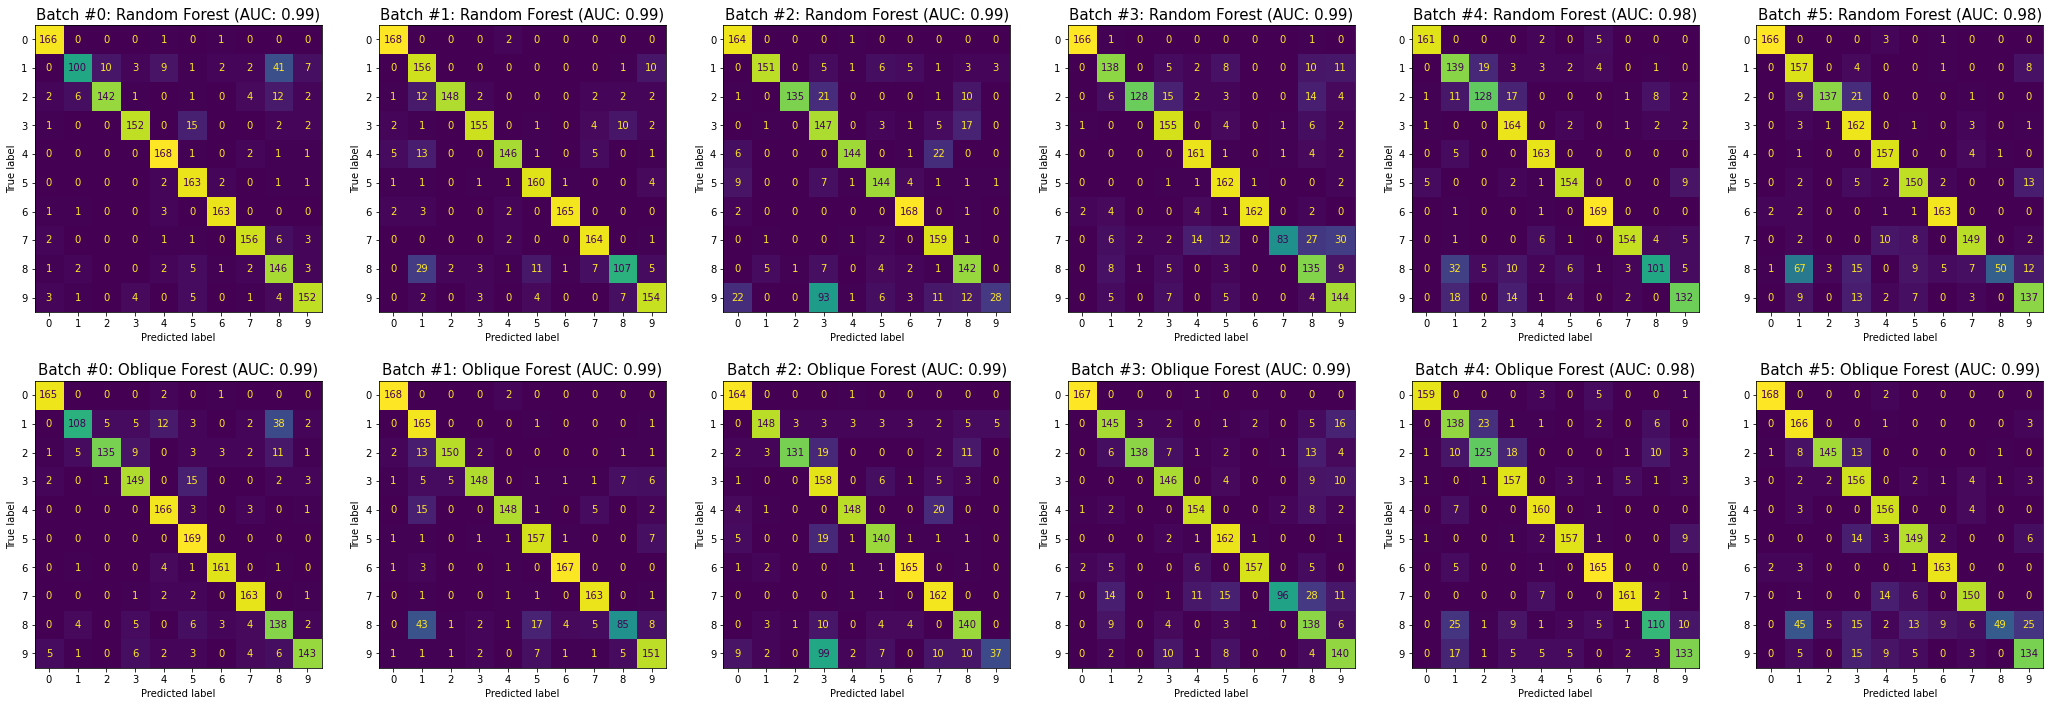

In [28]:
from sklearn import metrics

df_confusion = pd.DataFrame(confusion_matrix_batch).sort_values([1,0], ascending=False).to_numpy()

N = int(df_confusion.shape[0] / 2)

fig, ax = plt.subplots(2,N,figsize=(6*N,12))

for i, cm in enumerate(df_confusion):
    col = int(i%N)
    row = int(i//N)

    metrics.ConfusionMatrixDisplay.from_predictions(y_true=cm[2],y_pred=cm[3], colorbar=False, ax=ax[row,col])
    ax[row,col].set_title(f'Batch #{col}: {cm[1]} (AUC: {round(cm[4]["macro"],2)})', fontsize=15)

#### Refitting base tree with parameters from each iteration of grid searching

In [29]:
import _pickle as cPickle

def get_tree_size(df, random_state, savefile=True):

    N = df.shape[0]
    tree_size = []
    df.reset_index(drop=True, inplace=True)

    t_i = time.time()

    for i in range(N):
        
        row = df.iloc[i,:]

        if row['clf'] == 'RF':
            clf = RandomForestClassifier(random_state=random_state, **row['params'])
        elif row['clf'] == 'OF':
            clf = ObliqueRandomForestClassifier(random_state=random_state, **row['params'])
        else:
            print('Cannot identify estimator')

        clf.fit(X,y)
        tree_size.append(cPickle.dumps(clf).__sizeof__())

    new_df = pd.concat([df, pd.DataFrame(tree_size, columns=['clf_size'])], axis=1)

    print(f'Refitting trees took {int(time.time()-t_i)} seconds')

    if savefile:
        with open('mnist_runtime_output.pkl', 'wb') as handle:
            cPickle.dump(new_df, handle)

    return new_df

In [30]:
df_size = get_tree_size(df_cv, random_state=random_state)

Refitting trees took 39 seconds


In [248]:
df_size['clf_size_MB'] = df_size.apply(lambda x: x['clf_size']/10e6, axis=1)

#### Plot score versus performance metrics

In [73]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def bestfit(df, y, x='mean_test_score', clf='RF', degree=1):
    dff = df.query(f'clf == "{clf}"')

    # poly = PolynomialFeatures(degree=degree, include_bias=False)
    # poly_features = poly.fit_transform(dff[x].to_numpy().reshape(-1,1))

    # model = LinearRegression()
    # model.fit(poly_features, dff[y])
    # y_hat = model.predict(poly_features)

    # return y_hat

    y_hat = np.polyfit(dff[x], dff[y], degree)

    return np.poly1d(y_hat)

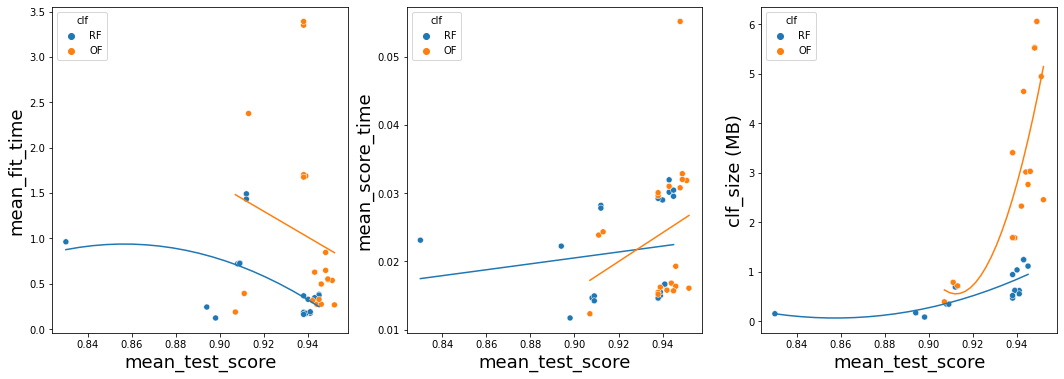

In [249]:
fig, ax = plt.subplots(1,3,figsize=(6*3,6))

var = {'x': 'mean_test_score',
       'y': ['mean_fit_time', 'mean_score_time', 'clf_size_MB'],
      }

for idx, y_var in enumerate(var['y']):

    sns.scatterplot(data=df_size, x=var['x'], y=y_var, hue='clf', ax=ax[idx])
    ax[idx].set_xlabel('mean_test_score', fontsize=18)
    ax[idx].set_ylabel(y_var, fontsize=18)

    for clf in ['RF', 'OF']:
        tmp_degree = {}
        tmp = df_size.query(f'clf=="{clf}"')[var['x']]
        qlow, qhigh = np.quantile(tmp,[0.00,1.0])
        x = np.linspace(qlow, qhigh, 20)

        for degree in [1,2]:
            model = bestfit(df=df_size, y=y_var, clf=clf, degree=degree)

            tmp_degree[degree] = r2_score(
                    y_true=df_size.query(f'clf=="{clf}"')[var['x']],
                    y_pred=model(x))

            # print(f'{tmp_degree[degree]}')

        max_idx = max(tmp_degree, key=tmp_degree.get)
        model = bestfit(df=df_size, y=y_var, clf=clf, degree=max_idx)
        ax[idx].plot(x, model(x))
        ax[idx].locator_params(axis='x', nbins=8)

        if idx == 2:
            ax[idx].set_ylabel('clf_size (MB)')

#### Binning Figure
The `mean_test_score` is quantized into N number of bins and each corresponding metric variable is plotted with respect to each bin

In [250]:
df_cut = pd.cut(df_size['mean_test_score'], 10).to_frame().reset_index(drop=True)
df_cut.columns = ['bins']
df_bin = pd.concat([df_size, df_cut], axis=1)
df_bin['bins_mid'] = df_bin.apply(lambda x: round(x['bins'].mid,2), axis=1)

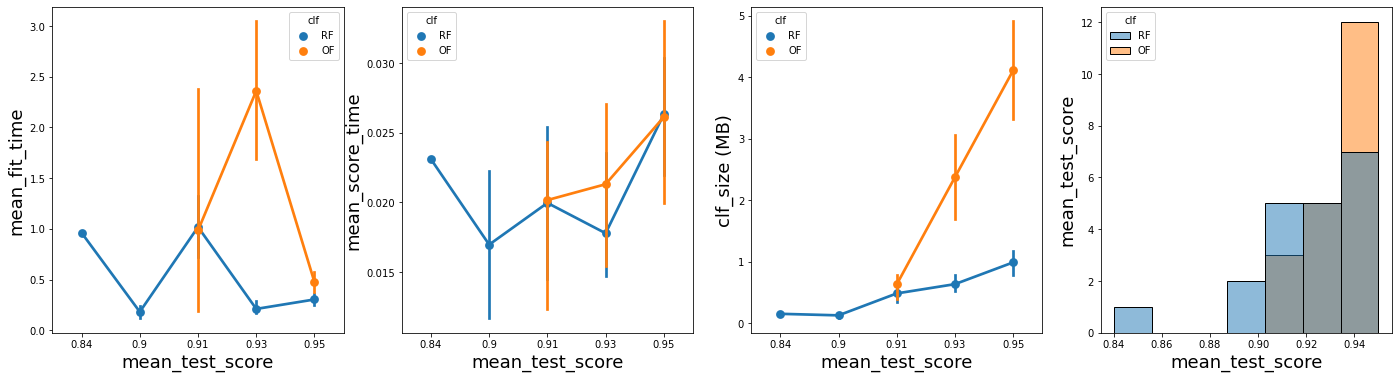

In [251]:
fig, ax = plt.subplots(1,4,figsize=(6*4,6*1));

for i, v in enumerate(var['y']):
    sns.pointplot(data=df_bin, x='bins_mid', y=v, hue='clf',ax=ax[i]);
    
sns.histplot(data=df_bin, x='bins_mid', hue='clf',ax=ax[3])

for i, l in enumerate(var['y'][:2]+['clf_size (MB)']+[var['x']]):
    ax[i].set_xlabel('mean_test_score', fontsize=18)
    ax[i].set_ylabel(l,fontsize=18)

#### Top 5 `mean_test_score` of each algorithm

In [76]:
df_cv_rf = df_cv[feat_cols[:5]].query('clf == "RF"').sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
df_cv_rf.head()

,max_features,n_estimators,max_depth,mean_test_score,clf
0,sqrt,200,15,0.945,RF
1,sqrt,200,20,0.945,RF
2,log2,200,20,0.943,RF
3,log2,200,None,0.943,RF
4,log2,100,15,0.941,RF


In [77]:
df_cv_of = df_cv[feat_cols[:5]].query('clf == "OF"').sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
df_cv_of.head()

,max_features,n_estimators,max_depth,mean_test_score,clf
0,log2,100,10,0.952,OF
1,log2,200,10,0.951,OF
2,log2,200,20,0.949,OF
3,log2,200,None,0.949,OF
4,sqrt,200,20,0.948,OF


### Visualization of parameterized grid search result

In [89]:
# Replacing None value as string so it shows on plotly
df_cv_rf.fillna('None', inplace=True)
df_cv_of.fillna('None', inplace=True)

In [87]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

fig = px.parallel_categories(
    df_cv_rf.iloc[:,:-1],
    color='mean_test_score'
)
fig.show()

In [88]:
px.parallel_categories(
    df_cv_of.iloc[:,:-1],
    color='mean_test_score'
)